# CS6140 - Neural Network Approach using LSTM

Recurrent neural networks (RNN) in general feature a context memory layer to incorporate previous state and current inputs for propagating information to the next state, and eventually the output layer for decision making. Canonical RNNs (simple RNNs) feature several different architectures, besides the Elman RNN for modelling temporal sequences and dynamical systems. One of the major challenges in training simple RNNs is due to the architecture’s properties of unfolding in time for long-term dependency problems. Backpropagation through time (BPTT), which is an extension of the backpropagation algorithm, has been prominent for training simple RNNs. Due to problem of learning long-term dependencies given vanishing and exploding gradients with simple RNNs, long short-term memory (LSTM) recurrent neural networks have been developed. LSTM networks have better capabilities for learning long-term dependencies in temporal data using memory cells and gates.

In [48]:
# Importing the libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report

In [49]:
# Importing train and test data
train = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')

test = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')

# Combaine train and test set
df = train.append(test, ignore_index=True)

In [50]:
# Converting sentiment into three features, Positive = 2 , Neutral = 1 , Negative =  0
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 2
    elif sentiment == "Extremely Negative":
        return 0
    elif sentiment == "Positive":
        return 2
    elif sentiment == "Negative":
        return 0
    else:
        return 1

In [51]:
# Applying convert_Sentiment function
df.Sentiment = df.Sentiment.apply(lambda x : convert_Sentiment(x))

0    3266
2    3092
1    1238
Name: Sentiment, dtype: int64
**********************************************************************


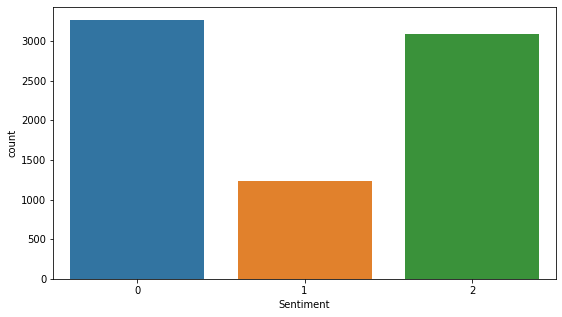

In [52]:
# Visualizing Sentiment distribution
print(df.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Sentiment',data = df)
plt.show()

## Data Pre-processing

Textual data in our corpus was cleaned by removing punctuations, url, html links, emojis and special characters.

In [53]:
# Cleaning textual data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Removing url
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Removing html links
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Separating words which have the same meaning
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

# Separating alphanumeric characters
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# Counting repeated characters
def cont_rep_char(text):
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2] 

# Finding unique characters
def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

# Substiting unique characters in sentences
def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Applying functions on OriginalTweet data
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

In [54]:
# Splitting sentiment labels 
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet

In [55]:
X = df['OriginalTweet']
y = df['Sentiment']

# Splitting the dataset into train and test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [56]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (6076,)
Shape of y_train :  (6076,)
Shape of X_test :  (1520,)
Shape of y_test :  (1520,)


In [57]:
# Converting y to categorical values
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

Tokenization of Tweets using Tokernizer() and text-to-sequences method.

In [58]:
# Tokenizing Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [59]:
# Converting tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Modeling Methodology

We present a Neural Network model using LSTM that compares multi-label classification.

In [60]:
# Creating a Sequential model using hyperparameters
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

LSTM Model Summary

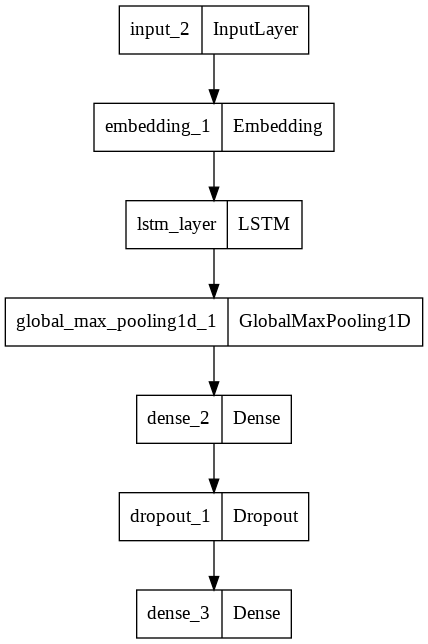

In [61]:
# Plotting the model summary for LSTM
import tensorflow as tf
tf.keras.utils.plot_model(model)

Compiling and training the model on train data

In [67]:
# Compiling the model using architectural layers and properties
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
# Training the model for 2 epochs
model.fit(X_train_final,y_train, epochs=2,validation_data=(X_test_final,y_test))

Epoch 1/2
190/190 [==============================] - 37s 175ms/step - loss: 0.0580 - accuracy: 0.9842 - val_loss: 0.3181 - val_accuracy: 0.9217
Epoch 2/2
190/190 [==============================] - 33s 173ms/step - loss: 0.0221 - accuracy: 0.9944 - val_loss: 0.4124 - val_accuracy: 0.9171


In [74]:
# Evaluating the model performance
model.evaluate(X_test_final,y_test)

48/48 [==============================] - 2s 45ms/step - loss: 0.4124 - accuracy: 0.9171


[0.4124337136745453, 0.9171052575111389]

In [75]:
# Predicting the model on test data
lstm_pred = np.round(model.predict(X_test_final))

In [76]:
# Performance scores on test data - Precision, Recall, F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       654
           1       0.87      0.91      0.89       263
           2       0.96      0.89      0.92       603

   micro avg       0.92      0.92      0.92      1520
   macro avg       0.91      0.91      0.91      1520
weighted avg       0.92      0.92      0.92      1520
 samples avg       0.92      0.92      0.92      1520



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
